In [2]:
import ipywidgets as widgets
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import wot


No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [3]:
# Path to input files
FLE_COORDS_PATH ='../data/data/fle_coords.txt'
FULL_DS_PATH = '../data/data/ExprMatrix.h5ad'
VAR_DS_PATH = '../data/data/ExprMatrix.var.genes.h5ad'
CELL_DAYS_PATH = '../data/data/cell_days.txt'
GENE_SETS_PATH = '../data/data/gene_sets.gmx'
GENE_SET_SCORES_PATH = '../data/data/gene_set_scores.csv'
CELL_SETS_PATH = '../data/data/cell_sets.gmt'


Text(0.5, 1.0, 'Day')

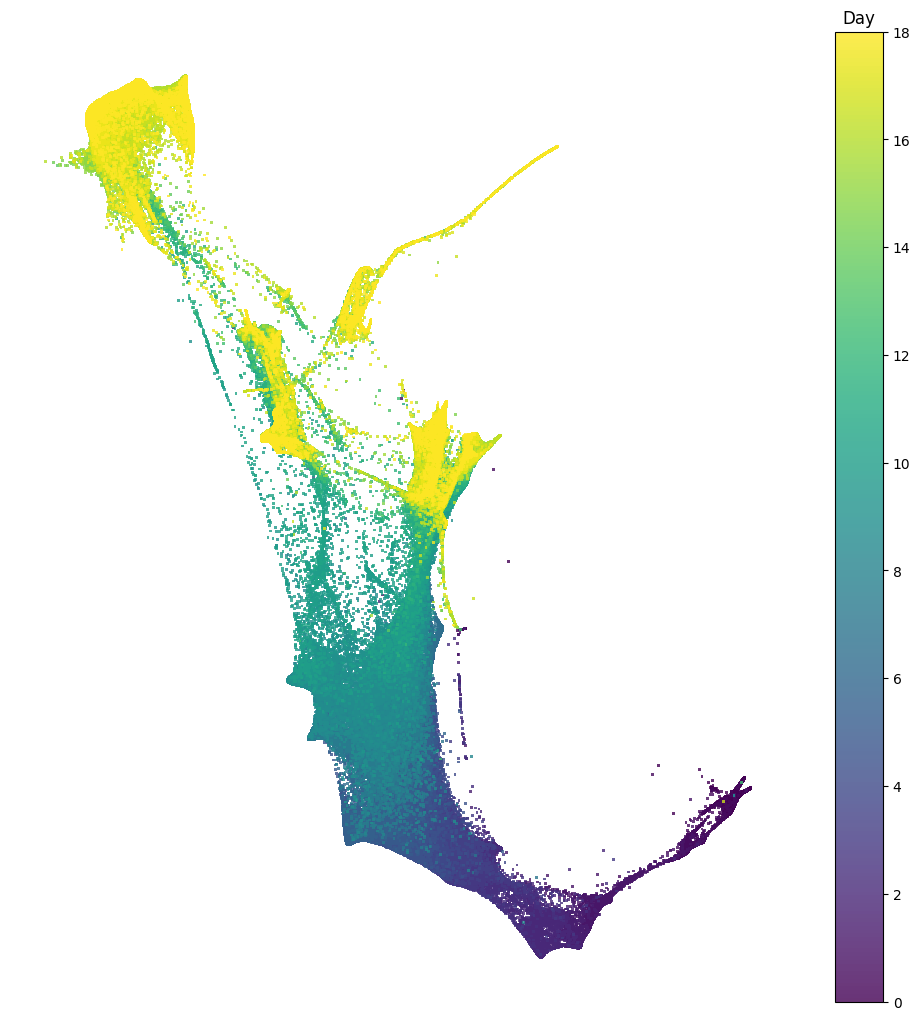

In [4]:
coord_df = pd.read_csv(FLE_COORDS_PATH, index_col='id', sep='\t')
days_df = pd.read_csv(CELL_DAYS_PATH, index_col='id', sep='\t')

# Read expression matrix, cell days, and 2-d coordinates
adata = wot.io.read_dataset(FULL_DS_PATH, obs=[days_df,coord_df])
unique_days = adata.obs['day'].unique()
unique_days = unique_days[np.isnan(unique_days) == False]
# plot visualization coordinates
figure = plt.figure(figsize=(10, 10))
plt.axis('off')
plt.tight_layout()
plt.scatter(adata.obs['x'], adata.obs['y'],c=adata.obs['day'],
               s=4, marker=',', edgecolors='none', alpha=0.8)
cb = plt.colorbar()
cb.ax.set_title('Day')


In [5]:
# Compute gene signature scores
gs = wot.io.read_sets(GENE_SETS_PATH, adata.var.index.values)
gene_set_scores_df = pd.DataFrame(index=adata.obs.index)
for j in range(gs.shape[1]):
    gene_set_name = str(gs.var.index.values[j])
    result = wot.score_gene_sets(ds=adata, gs=gs[:, [j]], permutations=0, method='mean_z_score')
    gene_set_scores_df[gene_set_name] = result['score']
gene_set_scores_df.to_csv(GENE_SET_SCORES_PATH, index_label='id')


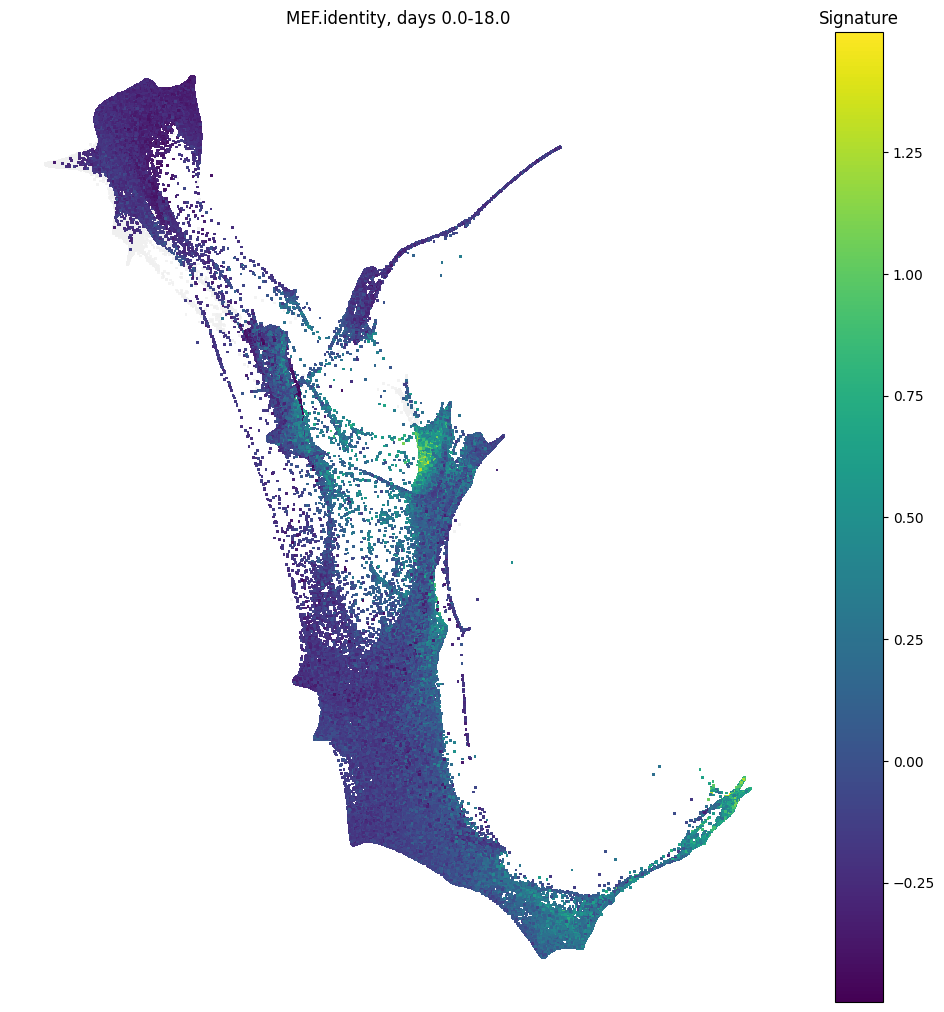

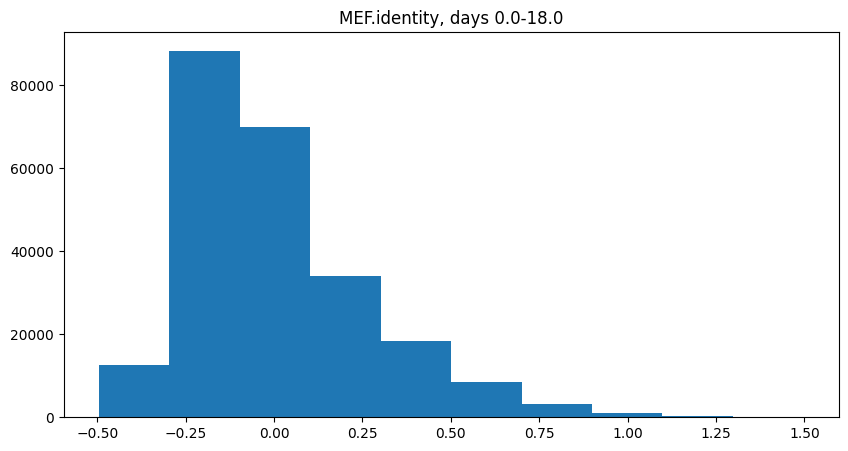

(<Figure size 1000x1000 with 2 Axes>, <Figure size 1000x500 with 1 Axes>)

interactive(children=(Dropdown(description='Gene Set:', options=('MEF.identity', 'Pluripotency', 'Cell.cycle',…

<function __main__.update_gene_set_vis(name, days)>

In [6]:
gene_set_scores_df = pd.read_csv(GENE_SET_SCORES_PATH,index_col='id')
gene_set_dropdown = widgets.Dropdown(
    options=gene_set_scores_df.columns,
    description='Gene Set:'
)

gene_set_scores_df = gene_set_scores_df.join(coord_df).join(days_df)
day_selector = widgets.SelectionRangeSlider(
    options=unique_days,
    continuous_update=False,
    index=(0,len(unique_days)-1),
    description='Days'
)

def update_gene_set_vis(name, days):
    gene_set_score_coords = gene_set_scores_df[(gene_set_scores_df['day']>=days[0]) & (gene_set_scores_df['day']<=days[1])]
    figure = plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.tight_layout()
    plt.title(name + ', days {}-{}'.format(days[0], days[1]))
    plt.scatter(coord_df['x'], coord_df['y'], c='#f0f0f0',
                   s=4, marker=',', edgecolors='none', alpha=0.8)
    plt.scatter(gene_set_score_coords['x'], gene_set_score_coords['y'], c=gene_set_score_coords[name],
                   s=4, marker=',', edgecolors='none')
    cb = plt.colorbar()
    cb.ax.set_title('Signature')
    figure2 = plt.figure(figsize=(10, 5))
    plt.title(name + ', days {}-{}'.format(days[0], days[1]))
    plt.hist(gene_set_score_coords[name])
    return figure, figure2

widgets.interact(update_gene_set_vis, name=gene_set_dropdown, days=day_selector)

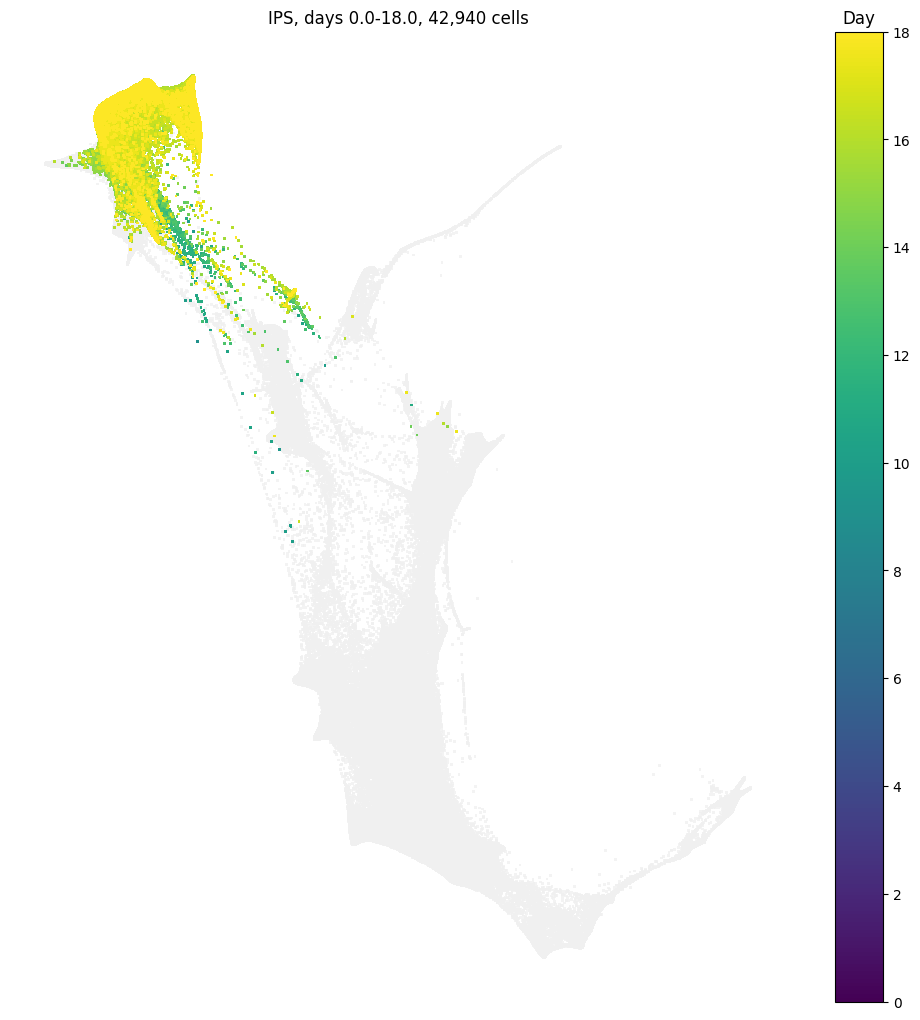

interactive(children=(Dropdown(description='Cell Set:', options=('IPS', 'Stromal', 'Neural', 'MET', 'Epithelia…

<function __main__.update_cell_set_vis(name, days)>

In [7]:
# Load cell sets
cell_sets = wot.io.read_sets(CELL_SETS_PATH)

# Visualize Cell Sets 
cell_set_dropdown = widgets.Dropdown(
    options=cell_sets.var.index,
    description='Cell Set:'
)

day_selector = widgets.SelectionRangeSlider(
    options=unique_days,
    continuous_update=False,
    index=(0,len(unique_days)-1),
    description='Days'
)

def update_cell_set_vis(name, days):
    cell_set = cell_sets[:, name]
    cell_set_coords = cell_set[cell_set.X>0].obs.join(coord_df).join(days_df)
    cell_set_coords = cell_set_coords[(cell_set_coords['day']>=days[0]) & (cell_set_coords['day']<=days[1])]
    figure = plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.tight_layout()
    plt.title(name + ', days {}-{}, {:,} cells'.format(days[0], days[1], cell_set_coords.shape[0]))
    plt.scatter(coord_df['x'], coord_df['y'], c='#f0f0f0',
                   s=4, marker=',', edgecolors='none', alpha=0.8)
    plt.scatter(cell_set_coords['x'], cell_set_coords['y'], c=cell_set_coords['day'],
                   s=4, marker=',', edgecolors='none', vmin=unique_days[0],  vmax=unique_days[len(unique_days)-1])
    cb = plt.colorbar()
    cb.ax.set_title('Day')

widgets.interact(update_cell_set_vis, name=cell_set_dropdown, days=day_selector)

In [8]:
# load proliferation and apoptosis scores
gene_set_scores = pd.read_csv('../data/data/gene_set_scores.csv', index_col=0)
proliferation=gene_set_scores['Cell.cycle']
apoptosis = gene_set_scores['Apoptosis']

# apply logistic function to transform to birth rate and death rate
def logistic(x, L, k, x0=0):
    f = L / (1 + np.exp(-k * (x - x0)))
    return f
def gen_logistic(p, beta_max, beta_min, pmax, pmin, center, width):
    return beta_min + logistic(p, L=beta_max - beta_min, k=4 / width, x0=center)

def beta(p, beta_max=1.7, beta_min=0.3, pmax=1.0, pmin=-0.5, center=0.25):
    return gen_logistic(p, beta_max, beta_min, pmax, pmin, center, width=0.5)

def delta(a, delta_max=1.7, delta_min=0.3, amax=0.5, amin=-0.4, center=0.1):
    return gen_logistic(a, delta_max, delta_min, amax, amin, center,
                          width=0.2)

birth = beta(proliferation)
death = delta(apoptosis)

# growth rate is given by 
gr = np.exp(birth-death)
growth_rates_df = pd.DataFrame(index=gene_set_scores.index, data={'cell_growth_rate':gr})
growth_rates_df.to_csv('../data/data/growth_gs_init.txt')

In [9]:
VAR_GENE_DS_PATH = '../data/data/ExprMatrix.var.genes.h5ad'
CELL_DAYS_PATH = '../data/data/cell_days.txt'
SERUM_CELL_IDS_PATH = '../data/data/serum_cell_ids.txt'
CELL_GROWTH_PATH = '../data/data/growth_gs_init.txt'

# load data
adata = wot.io.read_dataset(VAR_GENE_DS_PATH, obs=[CELL_DAYS_PATH, CELL_GROWTH_PATH], obs_filter=SERUM_CELL_IDS_PATH)
adata.shape

(175472, 1479)

In [10]:
# create OTModel
ot_model = wot.ot.OTModel(adata,epsilon = 0.05, lambda1 = 1,lambda2 = 50) 


In [11]:
# Compute a single transport map from day 7 to 7.5
tmap_annotated = ot_model.compute_transport_map(7,7.5)

In [12]:
# row annotations include cell growth rates
tmap_annotated.obs

# columns annotated by cell barcodes
# tmap_annotated.var

,g0,g1
index,,
D7_Dox_C1_AAACCTGAGGAATCGC-1,1.268895,0.977584
D7_Dox_C1_AAACCTGAGTAGATGT-1,2.978660,2.510210
D7_Dox_C1_AAACCTGCAACCGCCA-1,1.871918,1.789109
D7_Dox_C1_AAACCTGCACTATCTT-1,3.072989,2.790355
D7_Dox_C1_AAACCTGCAGCCTGTG-1,1.026225,0.918580
...,...,...
D7_Dox_C2_TTTGTCAAGTTAGCGG-1,0.338531,0.370486
D7_Dox_C2_TTTGTCACAGTGGAGT-1,0.582584,0.609164
D7_Dox_C2_TTTGTCAGTAATTGGA-1,0.254926,0.296703


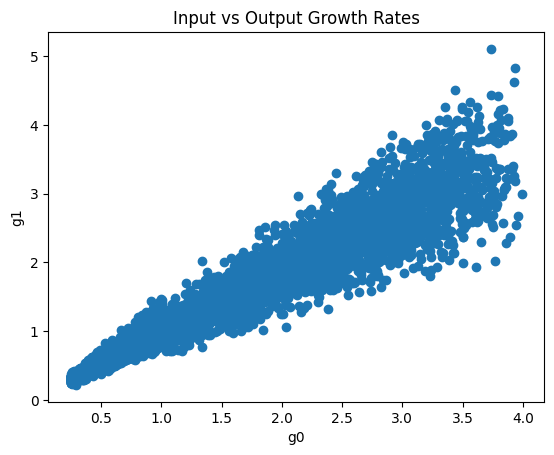

In [13]:
# Visualize how growth rates change with growth iterations
plt.scatter(tmap_annotated.obs['g0'],tmap_annotated.obs['g1'])
plt.xlabel("g0")
plt.ylabel("g1")
plt.title("Input vs Output Growth Rates")
plt.show()

In [14]:
ot_model_strict = wot.ot.OTModel(adata,epsilon = 0.05, lambda1 = 3,lambda2 = 50) 
tmap_anno_strict = ot_model_strict.compute_transport_map(7,7.5)

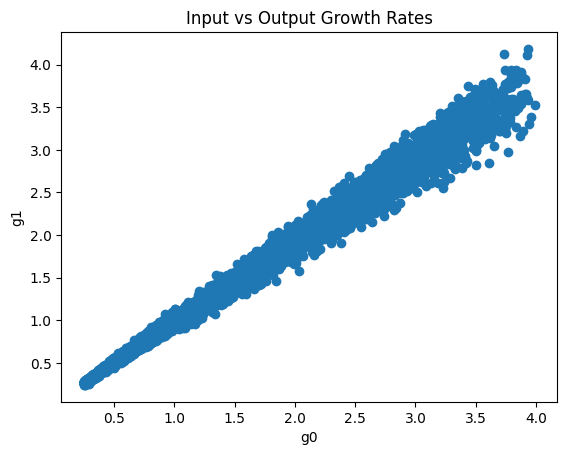

In [15]:
plt.scatter(tmap_anno_strict.obs['g0'],tmap_anno_strict.obs['g1'])
plt.xlabel("g0")
plt.ylabel("g1")
plt.title("Input vs Output Growth Rates")
plt.show()


In [16]:
# Updating growth estimates
ot_model_gr2 = wot.ot.OTModel(adata,epsilon = 0.05, lambda1 = 1,lambda2 = 50,growth_iters=2) 
tmap_anno_gr2 = ot_model_gr2.compute_transport_map(7,7.5)

In [17]:
# row annotations include initial cell growth rates g0, and also g1 and g2
tmap_anno_gr2.obs

,g0,g1,g2
index,,,
D7_Dox_C1_AAACCTGAGGAATCGC-1,1.268895,0.977584,0.771915
D7_Dox_C1_AAACCTGAGTAGATGT-1,2.978660,2.510210,2.130955
D7_Dox_C1_AAACCTGCAACCGCCA-1,1.871918,1.789109,1.692339
D7_Dox_C1_AAACCTGCACTATCTT-1,3.072989,2.790355,2.516846
D7_Dox_C1_AAACCTGCAGCCTGTG-1,1.026225,0.918580,0.815131
...,...,...,...
D7_Dox_C2_TTTGTCAAGTTAGCGG-1,0.338531,0.370486,0.397700
D7_Dox_C2_TTTGTCACAGTGGAGT-1,0.582584,0.609164,0.624181
D7_Dox_C2_TTTGTCAGTAATTGGA-1,0.254926,0.296703,0.334488


(array([   2.,    2.,   23.,   58.,  200.,  624., 1517., 1869.,  726.,
          40.]),
 array([1.40481301, 1.40735796, 1.40990291, 1.41244786, 1.41499281,
        1.41753776, 1.42008271, 1.42262766, 1.42517261, 1.42771756,
        1.43026251]),
 <BarContainer object of 10 artists>)

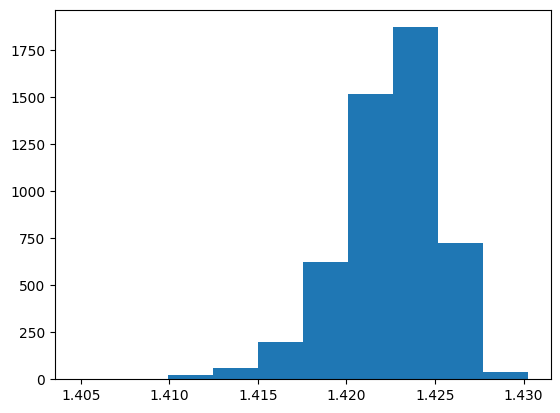

In [18]:
# Tuning λ1 and λ2
colsums = tmap_anno_gr2.X.sum(axis=0);
plt.hist(colsums)

In [ ]:
# Tuning ϵ

In [ ]:
# Compute all transport maps in batch mode

# ot_model = wot.ot.OTModel(adata, epsilon = 0.05, lambda1 = 1, lambda2 = 50, growth_iters = 3) 
# ot_model.compute_all_transport_maps(tmap_out='tmaps/serum')

# we can speed this up by supplying g2 and doing 1 growth iter

In [20]:
tmap_model = wot.tmap.TransportMapModel.from_directory('../data/tmaps/serum')

In [21]:
# Composing couplings
gamma_8_10 = tmap_model.get_coupling(8, 10)
gamma_8_10

AnnData object with n_obs × n_vars = 3815 × 2051
    obs: 'g0', 'g1', 'g2', 'g3'

In [22]:
import ipywidgets as widgets
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import wot

# input paths
FULL_DS_PATH = '../data/data/ExprMatrix.h5ad'
CELL_DAYS_PATH = '../data/data/cell_days.txt'
VAR_DS_PATH = '../data/data/ExprMatrix.var.genes.h5ad'
TMAP_PATH = '../data/tmaps/serum'
CELL_SETS_PATH = '../data/data/major_cell_sets.gmt'
COORDS_PATH = '../data/data/fle_coords.txt'

In [23]:
tmap_model = wot.tmap.TransportMapModel.from_directory(TMAP_PATH)
cell_sets = wot.io.read_sets(CELL_SETS_PATH, as_dict=True)
populations = tmap_model.population_from_cell_sets(cell_sets, at_time=12)


In [24]:
trajectory_ds = tmap_model.trajectories(populations)


In [25]:
# Load embedding coordinates
coord_df = pd.read_csv(COORDS_PATH, sep='\t', index_col=0)
nbins = 500
xrange = coord_df['x'].min(), coord_df['x'].max()
yrange = coord_df['y'].min(), coord_df['y'].max()
coord_df['x'] = np.floor(
    np.interp(coord_df['x'], [xrange[0], xrange[1]], [0, nbins - 1])).astype(int)
coord_df['y'] = np.floor(
    np.interp(coord_df['y'], [yrange[0], yrange[1]], [0, nbins - 1])).astype(int)
trajectory_ds.obs = trajectory_ds.obs.join(coord_df)

In [28]:
# Visualize trajectories
trajectory_dropdown = widgets.Dropdown(
    options=trajectory_ds.var.index,
    description='Trajectory:'
)

def update_trajectory_vis(name):
    figure = plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.tight_layout()
    plt.title(name)
    plt.scatter(coord_df['x'], coord_df['y'], c='#f0f0f0',
                   s=4, marker=',', edgecolors='none', alpha=0.8)
    binned_df = trajectory_ds.obs.copy()
    binned_df['values'] = trajectory_ds[:, name].X
    binned_df = binned_df.groupby(['x', 'y'], as_index=False).sum()
    plt.scatter(binned_df['x'], binned_df['y'], c=binned_df['values'],
                   s=6, marker=',', edgecolors='none', vmax=binned_df['values'].quantile(0.975))
    plt.colorbar().ax.set_title('Trajectory')



In [31]:
#widgets.interact(update_trajectory_vis, name=trajectory_dropdown)
#trajectory_ds.obs
trajectory_ds

AnnData object with n_obs × n_vars = 165892 × 5
    obs: 'day', 'x', 'y'

In [37]:
# Notebook 5: Fate Matrices
import math

In [32]:
# Load transport map model and cell sets
tmap_model = wot.tmap.TransportMapModel.from_directory('../data/tmaps/serum')
cell_sets = wot.io.read_sets('../data/data/major_cell_sets.gmt', as_dict=True)

In [33]:
# create indicator vectors for each cell set
target_destinations = tmap_model.population_from_cell_sets(cell_sets, at_time=18)


In [34]:
fate_ds = tmap_model.fates(target_destinations)

In [38]:
fate_dropdown1 = widgets.Dropdown(
    options=fate_ds.var.index,
    description='Fate 1:'
)
fate_dropdown2 = widgets.Dropdown(
    options=fate_ds.var.index,
    description='Fate 2:',
    value=fate_ds.var.index[1]
)
day_dropdown = widgets.Dropdown(
    options=fate_ds.obs['day'].unique(),
    description='Day',
    value=12
)


def update_fate_vis(name1, name2,day):
    figure = plt.figure(figsize=(10, 10))   

    fate1 = fate_ds[:,name1][fate_ds.obs['day']==day].X.flatten()
    fate2 = fate_ds[:,name2][fate_ds.obs['day']==day].X.flatten()

    Nrows = len(fate1)
    x = np.zeros(Nrows)
    y = np.zeros(Nrows)
    P = np.array([[1,0],[np.cos(2*math.pi/3),math.sin(2*math.pi/3)],[math.cos(4*math.pi/3),math.sin(4*math.pi/3)]])

    for i in range(0,Nrows):
        ff = np.array([fate1[i],fate2[i],1-(fate1[i]+fate2[i])])
        x[i] = (ff @ P)[0]
        y[i] = (ff @ P)[1]

    vx = P[:,0]
    vy = P[:,1]
    t1 = plt.Polygon(P, color=(0,0,0,0.1))
    plt.gca().add_patch(t1)
    
    plt.scatter(x,y)
    plt.scatter(vx,vy)
    #plt.scatter(0,0)
    plt.text(P[0,0]+.1, P[0,1], name1)
    plt.text(P[1,0]-.1, P[1,1]+.1, name2)
    plt.text(P[2,0]-.1, P[2,1]-.2, 'Other')
    plt.axis('equal')
    plt.axis('off')
    #plt.xticks([])
    #plt.yticks([])
    
    plt.title('{} vs. {} on day {}'.format(name1, name2,day))


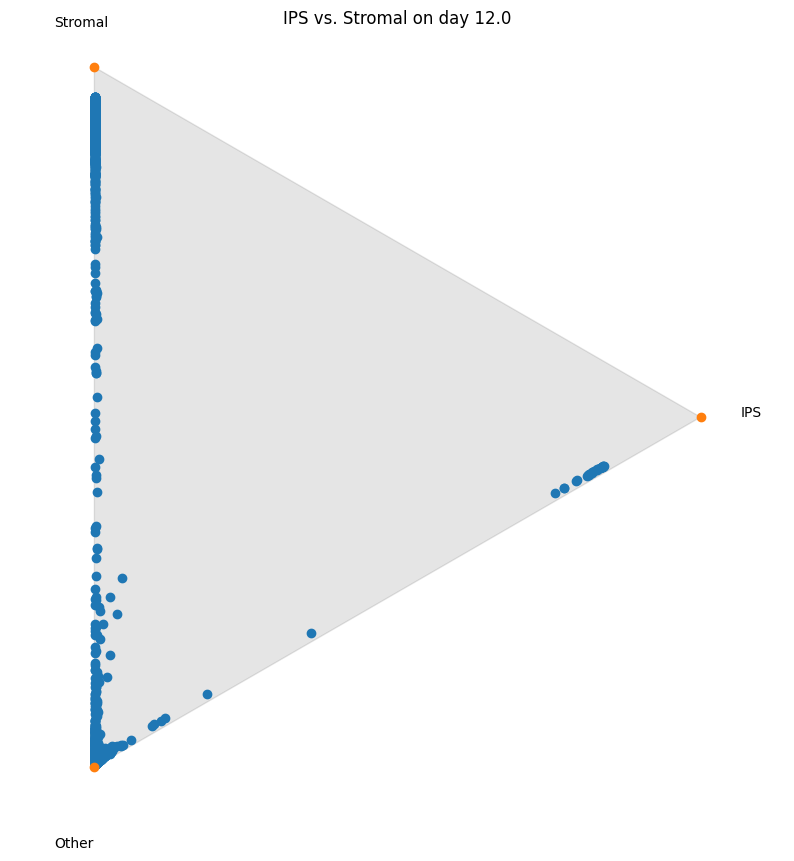

interactive(children=(Dropdown(description='Fate 1:', options=('IPS', 'Stromal', 'Neural', 'Trophoblast', 'Epi…

<function __main__.update_fate_vis(name1, name2, day)>

In [40]:
widgets.interact(update_fate_vis, name1=fate_dropdown1, name2=fate_dropdown2,day=day_dropdown)

In [41]:
fate_dropdown1 = widgets.Dropdown(
    options=fate_ds.var.index,
    description='Fate 1:'
)
fate_dropdown2 = widgets.Dropdown(
    options=fate_ds.var.index,
    description='Fate 2:',
    value=fate_ds.var.index[1]
)

def update_fate_vis(name1, name2):
    figure = plt.figure(figsize=(10, 10))
    fate1 = fate_ds[:, name1].X
    fate2 = fate_ds[:, name2].X
    p = np.log(1e-9 + np.divide(fate1, fate2, out=np.zeros_like(fate1), where=fate2 != 0))
    plt.scatter(fate_ds.obs['day'], p, s=4, marker=',')
    plt.xlabel('Day')
    plt.ylabel('Log Odds')
    plt.title('{} vs. {}'.format(name1, name2))


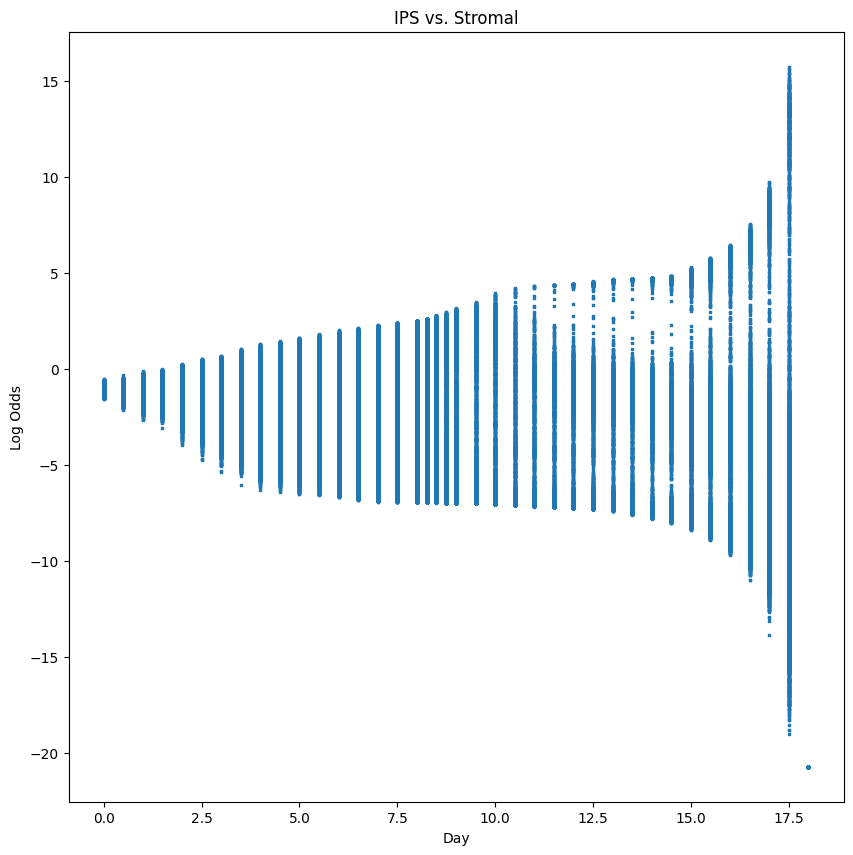

interactive(children=(Dropdown(description='Fate 1:', options=('IPS', 'Stromal', 'Neural', 'Trophoblast', 'Epi…

<function __main__.update_fate_vis(name1, name2)>

In [42]:
widgets.interact(update_fate_vis, name1=fate_dropdown1, name2=fate_dropdown2)